# Implementation of the GMRES algorithm

### Last:
- Implemented the Arnoldi Algorithm (Lecture 4)
- Problem: Arnoldi is supposed to generate a Hessian Matrix H, but in my implementation I believe, only a vector h may be generated, although its not implemented yet.


**Imports**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu

In [5]:
import numpy as np
from scipy.linalg import lu
A = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])
p, l, u = lu(A)
np.allclose(A, p @ l @ u)
p  # Permutation matrix
p, _, _ = lu(A, p_indices=True)
p
np.allclose(A, l[p, :] @ u)

True

**Helper Functions**

In [6]:
def unit_vector(direction=0, size=1):
    e = np.zeros(size)
    e[direction] = 1
    return e

def norm(v):
    return np.sqrt(v.dot(v))

def back_substitution(A, b):
    n = len(b)
    x = np.zeros(n)
    
    for i in range(n - 1, -1, -1):
        if A[i, i] == 0:
            raise ValueError("Matrix is singular at diagonal entry A[{},{}]".format(i, i))
        
        sum_ax = 0
        for j in range(i + 1, n):
            sum_ax += A[i, j] * x[j]
        
        x[i] = (b[i] - sum_ax) / A[i, i]
    
    return x

def back_substitution(U, b):
    n = len(b)
    x = np.zeros_like(b)
    for i in reversed(range(n)):
        if U[i, i] == 0:
            raise ValueError("Matrix is singular")
        x[i] = (b[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    return x

# Part 1: Algorithms and Data Structures
### MSR Reader

In [7]:
def string_to_numbers_array(s, dtype="float", sep=" "):
    if s[-1:] == "\n":
        s = s[:-1]
    str_arr = s.split(sep)
    str_arr = [num for num in str_arr if num != ""]

    if dtype == "float":
        num_arr = np.array([float(string.strip()) for string in str_arr], dtype="float")
    if dtype == "int":
        num_arr = np.array([int(string.strip()) for string in str_arr], dtype="int32")
        
    return num_arr

def msr_reader(path):

    # READ FILE
    bindx = []
    values = []
    with open(path) as f:
        lines = f.readlines()
        n, nnz = string_to_numbers_array(lines[1], dtype="int") 
        bindx = np.zeros(nnz, dtype="int32")
        values = np.zeros(nnz, dtype="float")
        for i, l in enumerate(lines):
            if i == 0:
                symmetric = True if (l[0] == "s") else False
            elif i > 1:
                b, v = string_to_numbers_array(l)
                bindx[i-2] = b
                values[i-2] = v

    # CONSTRUCT MATRIX
    A = np.zeros(n*n).reshape(n,n)
    # diagonal
    for i in range(n):
        A[i,i] = values[i]
    # off-diagonal
    off_counter = 0
    for row in range(n):
        noff = int(bindx[row+1] - bindx[row])
        for i in range(noff):
            col = bindx[(n+1) + off_counter]
            val = values[(n+1) + off_counter]
            A[row][col-1] = val
            off_counter += 1
    # symmetry
    if symmetric:
        for i in range(n):
            for j in range(i):
                A[j, i] = A[i, j]
    
    return A

### GMRES(m)

In [8]:
import numpy as np

def back_substitution(U, b):
    n = len(b)
    x = np.zeros_like(b)
    for i in reversed(range(n)):
        if U[i, i] == 0:
            raise ValueError("Matrix is singular")
        x[i] = (b[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    return x

def getKrylov(A, V, H, j):
    w = A @ V[j]
    for i in range(j + 1):
        H[i, j] = np.dot(V[i], w)
        w -= H[i, j] * V[i]
    H[j + 1, j] = np.linalg.norm(w)
    if H[j + 1, j] != 0:
        V[j + 1] = w / H[j + 1, j]
    return V, H

def GMRES_restarted(A, b, x0, m, tol, max_iterations=600):

    n = A.shape[0]
    x = x0.copy()

    # Initial residual
    r = b - A @ x
    r0_norm = np.linalg.norm(r)
    beta = r0_norm

    if r0_norm == 0:
        return x, [0.0]  # Already solved

    global_errors = [1.0]  # Initial relative residual is 1

    iteration = 0  # Global iteration counter

    while iteration < max_iterations:
        # Step 1: Initialize inner GMRES storage
        V = np.zeros((m + 1, n))
        H = np.zeros((m + 1, m))
        cs = np.zeros(m)
        sn = np.zeros(m)
        e1 = np.zeros(m + 1)

        # Step 2: Normalize residual and initialize Krylov basis
        r = b - A @ x
        beta = np.linalg.norm(r)

        if beta / r0_norm < tol:
            break

        V[0] = r / beta
        e1[0] = beta

        # Step 3: Inner GMRES loop (cycle of length m)
        for j in range(m):
            iteration += 1

            # Arnoldi
            V, H = getKrylov(A, V, H, j)

            # Apply previous Givens rotations
            for i in range(j):
                temp = cs[i] * H[i, j] + sn[i] * H[i + 1, j]
                H[i + 1, j] = -sn[i] * H[i, j] + cs[i] * H[i + 1, j]
                H[i, j] = temp

            # Compute new Givens rotation
            denom = np.hypot(H[j, j], H[j + 1, j])
            cs[j] = H[j, j] / denom if denom != 0 else 1.0
            sn[j] = H[j + 1, j] / denom if denom != 0 else 0.0

            # Apply new Givens rotation
            H[j, j] = cs[j] * H[j, j] + sn[j] * H[j + 1, j]
            H[j + 1, j] = 0.0

            # Update RHS vector
            temp = e1[j]
            e1[j] = cs[j] * temp
            e1[j + 1] = -sn[j] * temp

            # Relative residual estimate
            current_rel_residual = abs(e1[j + 1]) / r0_norm
            global_errors.append(current_rel_residual)

            # Check convergence
            if current_rel_residual < tol:
                y = back_substitution(H[:j + 1, :j + 1], e1[:j + 1])
                x = x + V[:j + 1].T @ y
                return x, global_errors

            if iteration >= max_iterations:
                break

        # End of cycle: update solution
        y = back_substitution(H[:m, :m], e1[:m])
        x = x + V[:m].T @ y

        # Final relative residual after restart
        r = b - A @ x
        beta = np.linalg.norm(r)
        rel_res = beta / r0_norm
        global_errors.append(rel_res)

        if rel_res < tol:
            break

    return x, global_errors

### Preconditioning

In [9]:
class Preconditioner:
    def __init__(self, A, type):
        self.A = A
        if type == "jacobi": self.M = self.jacobi()
        elif type == "gauss_seidel": self.M = self.gauss_seidel()
        elif type == "ilu0": self.M = self.ilu()

    def jacobi(self):
        n = self.A.shape[0]
        D = np.identity(n) * np.diag(self.A)
        return D
    
    def gauss_seidel(self):
        n = self.A.shape[0]
        L_vector = self.A[np.tril_indices(n, k=0)]
        L = np.zeros((n, n))
        L[np.tril_indices(n, k=0)] = L_vector
        return L

    def ilu0(self):
        """ Description
            The complete factorization is A = LU or for SPD matrices A = LL^T. Because the LU factorization
            can be dense, even if A is sparse, incomplete LU factorization allows the matrix fill only at
            pre-defined positions ij in a set P. In the case of the ILU(0) factorization, P includes all
            positions where A is non-zero.
            Pseudocode:
            for i=2,...,n
                for j=1,...,i-1
                    if (i,j) in P:
                        a_ij = a_ij/a_jj
                    for k = j+1,...,n
                        if (i,k) in P:
                            a_ik = a_ik - a_ij * a_jk
                    end
                end
            end
        """
        A = self.A.copy()
        n = A.shape[0]
        # Only fill in locations where A is non-zero
        nonzero = (A != 0)
        
        for i in range(1, n):
            for j in range(i):
                if nonzero[i, j]:
                    if A[j, j] == 0:
                        raise ZeroDivisionError(f"Zero diagonal at A[{j},{j}] during ILU(0)")
                    A[i, j] /= A[j, j]
                    for k in range(j + 1, n):
                        if nonzero[i, k]:
                            A[i, k] -= A[i, j] * A[j, k]

        return A

N = 4
X = np.random.randint(size=(N,N), high=10, low=1).reshape(N,N)
print(X)
print(Preconditioner(X, "ilu").M)

[[4 8 9 7]
 [6 7 6 3]
 [3 1 4 2]
 [1 7 7 6]]


AttributeError: 'Preconditioner' object has no attribute 'M'

### Complete LU Decomposition

In [ ]:
import numpy as np
N = 4
A = np.random.randint(size=(N,N), high=5, low=0).reshape(N,N)  + np.identity(N)
print(A)

# LU Decomposition
def LU_decomposition(A, reversed=False):

    # Verify square and non-zero entries on diagonal
    assert A.shape[0] == A.shape[1]
    N = A.shape[0]
    assert np.count_nonzero(np.diag(A)) == N, "Zero entries on diagonal"

    # Switch U and L if desired
    if reversed: U = A.T.copy()
    if not reversed: U = A.copy()

    # Perform Gauss Elimination A[row, col]
    for col in range(N-1):
        for row in range(1, N-col):
            mult_factor = U[row, col]/U[col, col]
            U[row,:] = U[row,:] - mult_factor * U[col, col]
    
    # Reverse back 
    if reversed:
        U = U.T
        L = A - U + np.identity(N)
    
    # Lower triangular matrix is A
    L = A
    
    return L, U

L, U = LU_decomposition(A, reversed=False)

linalg.lu(A)

[[2. 4. 1. 0.]
 [2. 1. 0. 4.]
 [1. 2. 4. 1.]
 [2. 0. 3. 4.]]


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_27960\554888482.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  mult_factor = A[row, col]/A[col, col]
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_27960\554888482.py:22: RuntimeWarning: invalid value encountered in scalar multiply
  A[row,:] = A[row,:] - mult_factor * A[col, col]
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_27960\554888482.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  U[row,:] = U[row,:] - mult_factor * U[col, col]


NameError: name 'linalg' is not defined

# Part 2: Convergence
### Read Matrix A

In [93]:
import os

path = os.getcwd()
matrices = ["cg_matrix_msr_1.txt", # 0
            "cg_matrix_msr_2.txt", # 1
            "gmres_matrix_msr_1.txt", # 2
            "msr_test_non_symmetric.txt", # 3
            "msr_test_symmetric.txt"] # 4

path = path + f"\\matrices\\{matrices[2]}"

A = msr_reader(path)

### Initial Conditions

In [10]:
n = A.shape[0]
x = np.ones(n)
x0 = np.zeros(n)
b = A.dot(x)
m = 600
tol = 1e-8

x_approx, errors = GMRES_restarted(A, b, x0, m, tol, max_iterations=600)

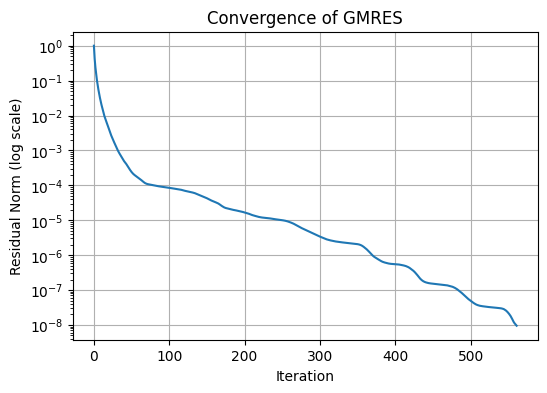

In [11]:
import matplotlib.pyplot as plt
import numpy as np

iterations = range(len(errors))

plt.figure(figsize=(6, 4))
plt.plot(iterations, np.abs(errors))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm (log scale)')
plt.title('Convergence of GMRES')
plt.grid(True)

plt.show()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

**Separated Arnoldi Algorithm**

I need to separate the Arnoldi Algorithm in order to implement it into the GMRES algorithm. However, I am not sure how exactly the matrices look like (shape). What is going where and 

In [12]:
from numpy.linalg import norm, lstsq

def gmres_restarted(A, b, x0, m, max_restarts, tol=1e-8):
    """
    Solves the linear system Ax = b using restarted GMRES.
    
    Parameters:
        A : np.ndarray
            Coefficient matrix (assumed square)
        b : np.ndarray
            Right-hand side vector
        x0 : np.ndarray
            Initial guess for the solution
        m : int
            Dimension of the Krylov subspace (inner iterations)
        max_restarts : int
            Maximum number of restart cycles
        tol : float
            Tolerance for convergence based on residual norm

    Returns:
        x : np.ndarray
            Approximate solution after convergence or max_restarts
    """
    x = x0.copy()  # Initialize current solution

    for restart in range(max_restarts):
        # Compute the residual vector at the current approximation
        r = b - A @ x
        residual_norm = norm(r)

        # Print current residual norm for tracking progress
        print(f"Restart {restart}: Residual norm = {residual_norm:.2e}")

        # Check for convergence
        if residual_norm < tol:
            break

        # Generate Krylov subspace vectors and Hessenberg matrix using Arnoldi
        V, H, beta = arnoldi(A, b, x, m)

        # Construct e₁ = [β, 0, 0, ..., 0] ∈ ℝ^{m+1}
        e1 = np.zeros(m+1)
        e1[0] = beta

        # Solve the least-squares problem min || H y - β e₁ ||
        # This gives the best approximation within the Krylov subspace
        y, _, _, _ = lstsq(H, e1, rcond=None)

        # Update the solution: x ← x + V_m y
        x += V[:, :m] @ y

    return x

In [3]:
N=10
A = np.random.randint(low=1,high=9,size=(N,N))
x = np.random.randint(low=1,high=9,size=N)
b = A.dot(x)
x0 = np.random.randint(low=1,high=9, size=N)

V, H, beta = arnoldi(A, b, x0, 4)
V

NameError: name 'arnoldi' is not defined

### GMRES Algorithm

In [197]:
def gmres(A, x0, b, m, tol):
    """
    A: 2D numpy array - square
    x0: 1D numpy array - initial guess
    b: 1D numpy array - right hand side
    m: integer - numer of iterations
    tol: float - tolerance
    """
    # Declaration
    N = np.size(A, 0) # size of the square matrix (NxN)
    R = np.zeros((m+1, N))
    V = np.zeros((m+1, N))
    H = 0

    # Initialisation
    R[0] = b - A.dot(x0)
    norm_r0 = norm(R[0])
    V[0] = R[0] / norm_r0
    g = norm_r0 * unit_vector(0, N)

    for j in range(m):
        V[j+1], 

    return R

In [229]:
import numpy as np

H = np.array([[1, 1, 4], 
              [2, 5, 2], 
              [0, 6, 3]], dtype=float)

# First rotation to eliminate H[1, 0]
phi1 = np.arctan(H[1, 0] / H[0, 0])  # angle in radians

# Optional: to view the angle in degrees
deg1 = np.rad2deg(phi1)

c1, s1 = np.cos(phi1), np.sin(phi1)

G1 = np.array([[ c1, s1, 0],
               [-s1, c1, 0],
               [  0,  0, 1]])

H_rot1 = G1.dot(H)

# Second rotation to eliminate H_rot1[2, 1]
phi2 = np.arctan(H_rot1[2, 1] / H_rot1[1, 1])

# Optional: view angle
deg2 = np.rad2deg(phi2)

c2, s2 = np.cos(phi2), np.sin(phi2)

G2 = np.array([[1,   0,  0],
               [0,  c2, s2],
               [0, -s2, c2]])

H_rot2 = G2 @ H_rot1

In [ ]:
A = np.random.random(size=(100000000))
B = np.zeros(100000000)
for i, a in enumerate(A):
    B[i] = a

In [302]:
A = np.random.random(size=(10000000))
B = np.zeros(10000000)
for i, a in enumerate(A):
    B[i] = a